In [3]:
import pandas as pd

# 데이터 파일이 저장된 경로 설정 (notebooks 폴더 기준)
data_path = '../data/raw/'

# --- 1. ChEMBL 파일 확인 ---
print("=== 1. ChEMBL_ASK1(IC50).csv 컬럼 목록 ===")
try:
    # ChEMBL 데이터는 세미콜론(;)으로 구분되어 있을 수 있습니다.
    chembl_df = pd.read_csv(data_path + 'ChEMBL_ASK1(IC50).csv', sep=';')
    print(f"총 컬럼 개수: {len(chembl_df.columns)}")
    print("컬럼 목록:")
    for i, col in enumerate(chembl_df.columns):
        print(f"  {i+1}. {col}")
    print(f"\n데이터 행 수: {len(chembl_df)}\n")
except Exception as e:
    print(f"파일을 읽는 중 오류가 발생했습니다: {e}")


# --- 2. PubChem 파일 확인 ---
print("============================================================")
print("\n=== 2. Pubchem_ASK1.csv 컬럼 목록 ===")
try:
    # DtypeWarning을 피하기 위해 low_memory=False 옵션 추가
    pubchem_df = pd.read_csv(data_path + 'Pubchem_ASK1.csv', low_memory=False)
    print(f"총 컬럼 개수: {len(pubchem_df.columns)}")
    print("컬럼 목록:")
    for i, col in enumerate(pubchem_df.columns):
        print(f"  {i+1}. {col}")
    print(f"\n데이터 행 수: {len(pubchem_df)}\n")
except Exception as e:
    print(f"파일을 읽는 중 오류가 발생했습니다: {e}")


# --- 3. CAS (Excel) 파일 확인 (!!! UPDATED !!!) ---
print("============================================================")
print("\n=== 3. CAS_KPBMA_MAP3K5_IC50s.xlsx 컬럼 목록 ===")
try:
    # 두 번째 시트를 읽고, 첫 번째 행을 건너뛰도록 옵션 수정
    cas_df = pd.read_excel(
        data_path + 'CAS_KPBMA_MAP3K5_IC50s.xlsx',
        sheet_name=1,      # 두 번째 시트
        skiprows=1         # 첫 번째 행 건너뛰기
    )
    print(f"총 컬럼 개수: {len(cas_df.columns)}")
    print("컬럼 목록:")
    for i, col in enumerate(cas_df.columns):
        print(f"  {i+1}. {col}")
    print(f"\n데이터 행 수: {len(cas_df)}\n")
except Exception as e:
    print(f"파일을 읽는 중 오류가 발생했습니다: {e}")

=== 1. ChEMBL_ASK1(IC50).csv 컬럼 목록 ===
총 컬럼 개수: 48
컬럼 목록:
  1. Molecule ChEMBL ID
  2. Molecule Name
  3. Molecule Max Phase
  4. Molecular Weight
  5. #RO5 Violations
  6. AlogP
  7. Compound Key
  8. Smiles
  9. Standard Type
  10. Standard Relation
  11. Standard Value
  12. Standard Units
  13. pChEMBL Value
  14. Data Validity Comment
  15. Comment
  16. Uo Units
  17. Ligand Efficiency BEI
  18. Ligand Efficiency LE
  19. Ligand Efficiency LLE
  20. Ligand Efficiency SEI
  21. Potential Duplicate
  22. Assay ChEMBL ID
  23. Assay Description
  24. Assay Type
  25. BAO Format ID
  26. BAO Label
  27. Assay Organism
  28. Assay Tissue ChEMBL ID
  29. Assay Tissue Name
  30. Assay Cell Type
  31. Assay Subcellular Fraction
  32. Assay Parameters
  33. Assay Variant Accession
  34. Assay Variant Mutation
  35. Target ChEMBL ID
  36. Target Name
  37. Target Organism
  38. Target Type
  39. Document ChEMBL ID
  40. Source ID
  41. Source Description
  42. Document Journal
  43. Docume

In [4]:
import numpy as np
import pandas as pd

# 이전에 데이터를 로드하여 chembl_df, pubchem_df, cas_df가 생성되었다고 가정합니다.

# --- 1. ChEMBL 데이터 처리 ---
print("1. ChEMBL 데이터 처리 중...")
# Standard Type이 'IC50'이고 Standard Relation이 '='인 데이터만 필터링
# 등호가 따옴표로 묶여있을 수 있으므로 "'='"로 확인
chembl_processed = chembl_df[
    (chembl_df['Standard Type'] == 'IC50') &
    (chembl_df['Standard Relation'] == "'='")
].copy() # SettingWithCopyWarning 방지를 위해 .copy() 사용

# pChEMBL 값은 숫자형으로 변환 (변환 불가 시 NaN 처리)
chembl_processed['pChEMBL Value'] = pd.to_numeric(chembl_processed['pChEMBL Value'], errors='coerce')

# 핵심 컬럼 선택 및 이름 변경
chembl_final = chembl_processed[[
    'Smiles', 'Standard Value', 'Standard Units', 'pChEMBL Value'
]].rename(columns={
    'Smiles': 'smiles',
    'Standard Value': 'standard_value',
    'Standard Units': 'units',
    'pChEMBL Value': 'p_value'
})
# 필수 값(smiles, standard_value, units)이 없는 행은 제거
chembl_final.dropna(subset=['smiles', 'standard_value', 'units'], inplace=True)
print(f"  -> 처리 후 ChEMBL 데이터: {len(chembl_final)} 행\n")


# --- 2. PubChem 데이터 처리 ---
print("2. PubChem 데이터 처리 중...")
# Activity_Type이 'IC50'이고 Activity_Qualifier가 '='인 데이터만 필터링
pubchem_processed = pubchem_df[
    (pubchem_df['Activity_Type'] == 'IC50') &
    (pubchem_df['Activity_Qualifier'] == '=')
].copy()

# 핵심 컬럼 선택 및 이름 변경
pubchem_final = pubchem_processed[['SMILES', 'Activity_Value']].rename(columns={
    'SMILES': 'smiles',
    'Activity_Value': 'standard_value'
})
# 단위 정보가 없으므로 가장 흔한 'nM'으로 가정하고, p_value는 없으므로 NaN으로 채움
pubchem_final['units'] = 'nM'
pubchem_final['p_value'] = np.nan

# 필수 값이 없는 행은 제거
pubchem_final.dropna(subset=['smiles', 'standard_value'], inplace=True)
print(f"  -> 처리 후 PubChem 데이터: {len(pubchem_final)} 행\n")


# --- 3. CAS 데이터 처리 ---
print("3. CAS 데이터 처리 중...")
cas_processed = cas_df.copy()

# 핵심 컬럼 선택 및 이름 변경
cas_final = cas_processed[['SMILES', 'Single Value (Parsed)', 'Measurement Unit', 'pX Value']].rename(columns={
    'SMILES': 'smiles',
    'Single Value (Parsed)': 'standard_value',
    'Measurement Unit': 'units',
    'pX Value': 'p_value'
})

# 필수 값이 없는 행은 제거
cas_final.dropna(subset=['smiles', 'standard_value', 'units'], inplace=True)
print(f"  -> 처리 후 CAS 데이터: {len(cas_final)} 행\n")


# --- 결과 확인 ---
print("--- 각 데이터프레임 처리 후 상위 5개 행 ---")
print("\n[ChEMBL 최종 데이터]")
print(chembl_final.head())
print("\n[PubChem 최종 데이터]")
print(pubchem_final.head())
print("\n[CAS 최종 데이터]")
print(cas_final.head())

1. ChEMBL 데이터 처리 중...
  -> 처리 후 ChEMBL 데이터: 715 행

2. PubChem 데이터 처리 중...
  -> 처리 후 PubChem 데이터: 431 행

3. CAS 데이터 처리 중...
  -> 처리 후 CAS 데이터: 3034 행

--- 각 데이터프레임 처리 후 상위 5개 행 ---

[ChEMBL 최종 데이터]
                                              smiles  standard_value units  \
0   Cn1cc(Cl)c2cnc(NC(=O)c3ccc([C@](C)(O)CO)cc3)cc21            38.0    nM   
1         Cc1cc2c(-c3ccc(S(=O)(=O)NCCN)s3)ccnc2[nH]1           251.0    nM   
2  Cc1cc(C)c2nc(N3C(=O)C(O)=C(C(=O)c4ccc(Cl)cc4)C...          6300.0    nM   
3  Cc1ccc(C(=O)C2=C(O)C(=O)N(c3nc4ccc(F)cc4s3)C2c...          7600.0    nM   
4  CCOc1ccc2nc(N3C(=O)C(O)=C(C(=O)c4ccccc4)C3c3cc...          4200.0    nM   

   p_value  
0     7.42  
1     6.60  
2     5.20  
3     5.12  
4     5.38  

[PubChem 최종 데이터]
                                              smiles  standard_value units  \
0  CC1=CC(=C(C=C1S(=O)(=O)N)C(=O)NC2=CC=CC(=N2)C3...         0.00010    nM   
1  CCS(=O)(=O)NC1=CC(=C(C=C1)OC)C(=O)NC2=CC=CC(=N...         0.00032    nM   
3  C

'outputs/figures/standard_value_distribution.png' 파일에 플롯이 저장되었습니다.


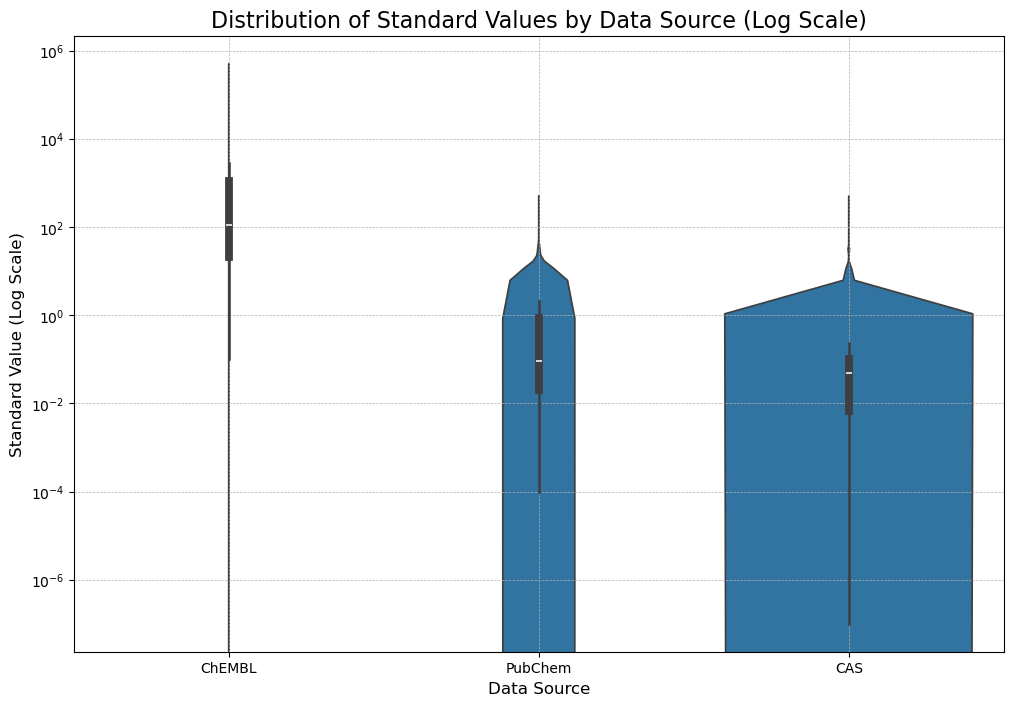

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화를 위해 각 데이터프레임에 출처(source)를 표시하는 컬럼 추가
chembl_final['source'] = 'ChEMBL'
pubchem_final['source'] = 'PubChem'
cas_final['source'] = 'CAS'

# 세 개의 데이터프레임을 하나로 합치기
combined_df = pd.concat([
    chembl_final[['standard_value', 'source']],
    pubchem_final[['standard_value', 'source']],
    cas_final[['standard_value', 'source']]
], ignore_index=True)

# 데이터 타입이 숫자가 아닐 수 있으므로 숫자형으로 변환 (오류 발생 시 NaN 처리)
combined_df['standard_value'] = pd.to_numeric(combined_df['standard_value'], errors='coerce')
combined_df.dropna(subset=['standard_value'], inplace=True)

# --- 바이올린 플롯 생성 ---
plt.figure(figsize=(12, 8))
ax = sns.violinplot(x='source', y='standard_value', data=combined_df)

# y축을 로그 스케일로 변경하여 분포를 명확하게 확인
ax.set_yscale('log')

ax.set_title('Distribution of Standard Values by Data Source (Log Scale)', fontsize=16)
ax.set_xlabel('Data Source', fontsize=12)
ax.set_ylabel('Standard Value (Log Scale)', fontsize=12)
plt.grid(True, which="both", ls="--", linewidth=0.5)

# 생성된 플롯을 이미지 파일로 저장
plt.savefig('../outputs/figures/standard_value_distribution.png', dpi=300)

print("'outputs/figures/standard_value_distribution.png' 파일에 플롯이 저장되었습니다.")
# In a Jupyter environment, the plot will also be displayed below the cell.

'outputs/figures/pic50_distribution.png' 파일에 플롯이 저장되었습니다.


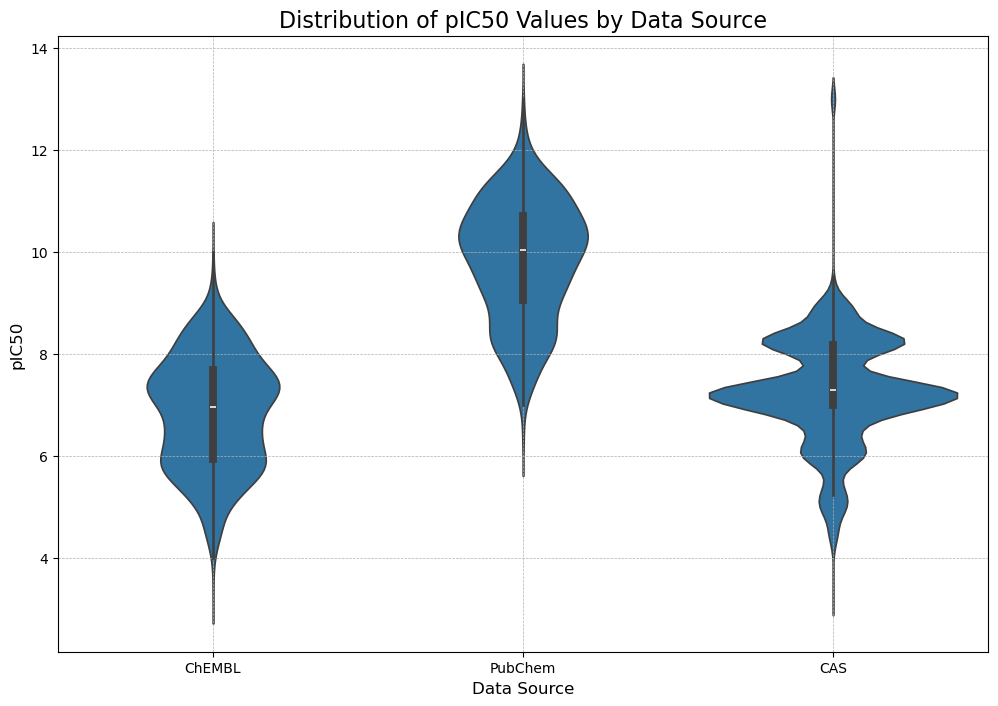

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# pIC50 값을 계산하는 함수 정의
def calculate_pic50(row):
    # 이미 p_value (pChEMBL, pX Value)가 있고 유효한 숫자인 경우, 그 값을 우선 사용
    if pd.notna(row['p_value']) and isinstance(row['p_value'], (int, float)):
        return row['p_value']
    
    # p_value가 없는 경우 standard_value와 units로 직접 계산
    value = row['standard_value']
    units = str(row['units']).lower()
    
    # 단위를 몰(M) 단위로 변환
    if 'nm' in units:
        molar_value = value * 1e-9
    elif 'um' in units or 'µm' in units:
        molar_value = value * 1e-6
    else:
        return np.nan # 알려진 단위가 아니면 NaN 반환

    # pIC50 계산 (-log10(Molar))
    # 값이 0보다 커야 로그 계산 가능
    if molar_value > 0:
        return -np.log10(molar_value)
    else:
        return np.nan

# --- 각 데이터프레임에 pIC50 컬럼 추가 ---
chembl_final['pIC50'] = chembl_final.apply(calculate_pic50, axis=1)
pubchem_final['pIC50'] = pubchem_final.apply(calculate_pic50, axis=1)
cas_final['pIC50'] = cas_final.apply(calculate_pic50, axis=1)

# 계산 후 결측치가 생겼을 수 있으므로 제거
chembl_final.dropna(subset=['pIC50'], inplace=True)
pubchem_final.dropna(subset=['pIC50'], inplace=True)
cas_final.dropna(subset=['pIC50'], inplace=True)


# --- 시각화를 위해 다시 하나로 합치기 ---
combined_pic50_df = pd.concat([
    chembl_final[['pIC50', 'source']],
    pubchem_final[['pIC50', 'source']],
    cas_final[['pIC50', 'source']]
], ignore_index=True)


# --- 새로운 pIC50 분포도 그리기 ---
plt.figure(figsize=(12, 8))
ax = sns.violinplot(x='source', y='pIC50', data=combined_pic50_df)

ax.set_title('Distribution of pIC50 Values by Data Source', fontsize=16)
ax.set_xlabel('Data Source', fontsize=12)
ax.set_ylabel('pIC50', fontsize=12)
plt.grid(True, which="both", ls="--", linewidth=0.5)

# 생성된 플롯을 이미지 파일로 저장
plt.savefig('../outputs/figures/pic50_distribution.png', dpi=300)

print("'outputs/figures/pic50_distribution.png' 파일에 플롯이 저장되었습니다.")

Data loading and initial processing complete.
Standard Value comparison plot saved to '/home/nudge/Project/ASK1_portfolio/outputs/figures/std_value_comparison.png'
pIC50 comparison plot saved to '/home/nudge/Project/ASK1_portfolio/outputs/figures/pic50_comparison.png'


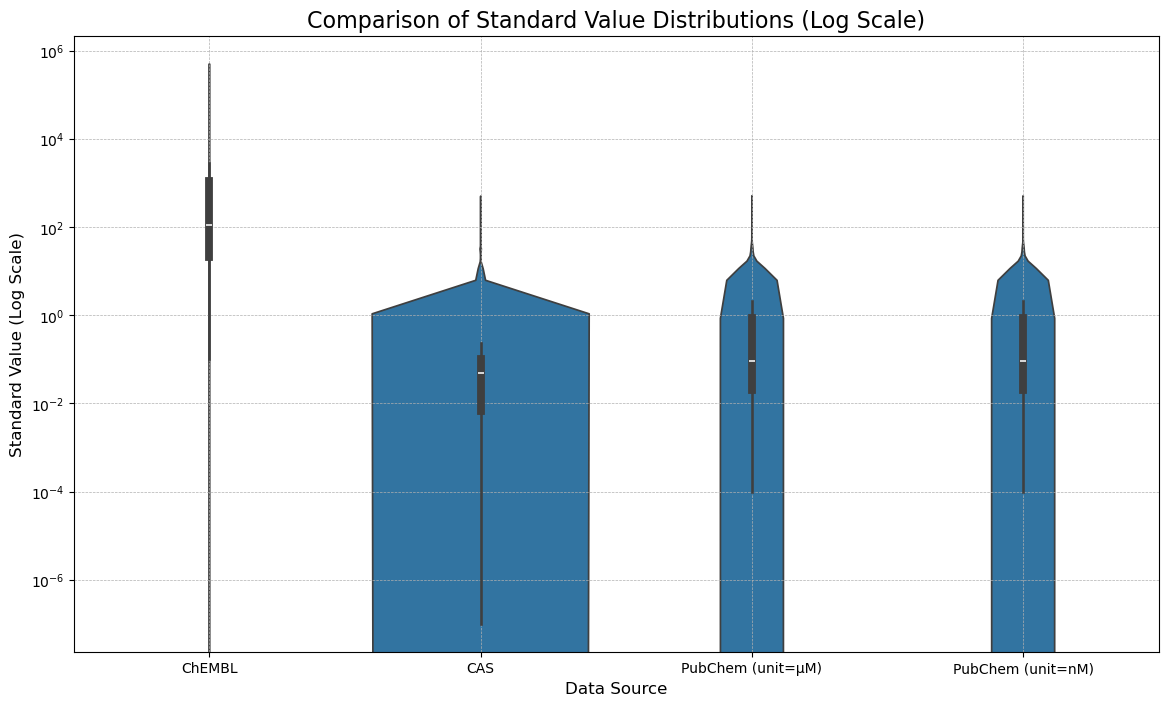

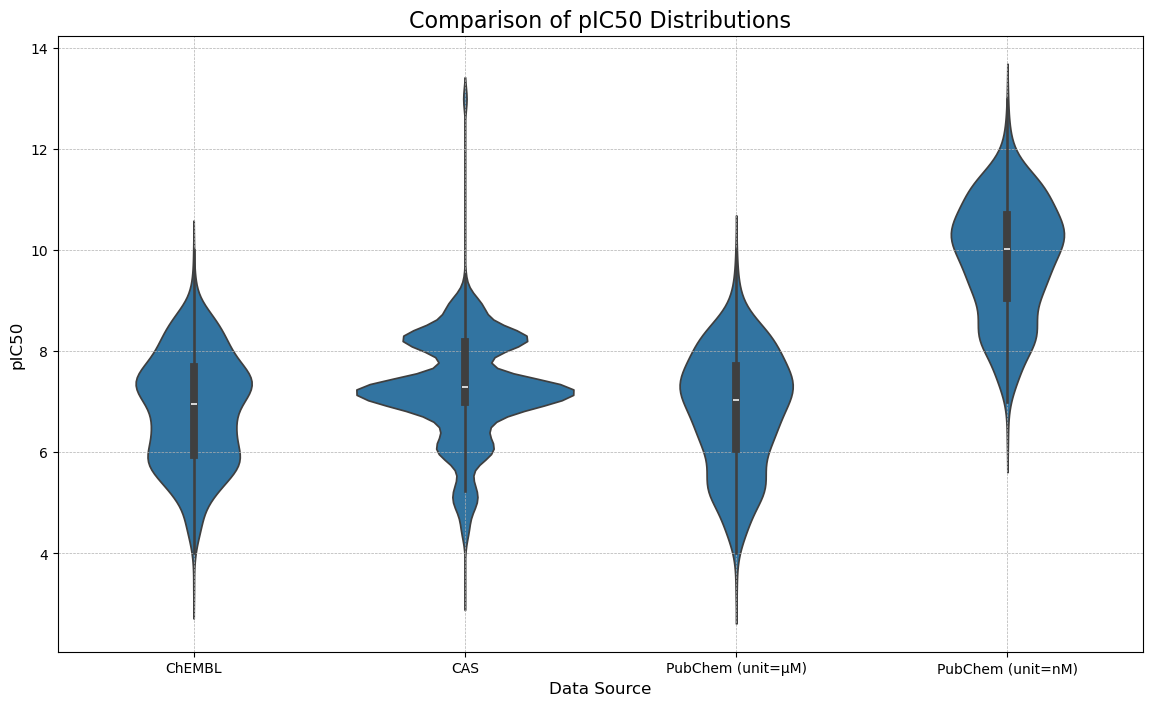

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Load and Process Data (Using Absolute Paths) ---

# Define data path using the full, absolute path
# This removes any ambiguity about the current working directory.
project_root = '/home/nudge/Project/ASK1_portfolio/'
data_path = project_root + 'data/raw/'
output_path = project_root + 'outputs/figures/'


# Load raw files
try:
    chembl_df = pd.read_csv(data_path + 'ChEMBL_ASK1(IC50).csv', sep=';')
    pubchem_df = pd.read_csv(data_path + 'Pubchem_ASK1.csv', low_memory=False)
    cas_df = pd.read_excel(data_path + 'CAS_KPBMA_MAP3K5_IC50s.xlsx', sheet_name=1, skiprows=1)
except FileNotFoundError as e:
    print(f"Error loading data files: {e}")
    print("Please double-check that the absolute path is correct.")
    exit()

# --- Data Processing (remains the same) ---
chembl_processed = chembl_df[(chembl_df['Standard Type'] == 'IC50') & (chembl_df['Standard Relation'] == "'='")].copy()
chembl_processed['pChEMBL Value'] = pd.to_numeric(chembl_processed['pChEMBL Value'], errors='coerce')
chembl_final = chembl_processed[['Smiles', 'Standard Value', 'Standard Units', 'pChEMBL Value']].rename(columns={'Smiles': 'smiles', 'Standard Value': 'standard_value', 'Standard Units': 'units', 'pChEMBL Value': 'p_value'})
chembl_final.dropna(subset=['smiles', 'standard_value', 'units'], inplace=True)

pubchem_processed = pubchem_df[(pubchem_df['Activity_Type'] == 'IC50') & (pubchem_df['Activity_Qualifier'] == '=')].copy()
pubchem_final = pubchem_processed[['SMILES', 'Activity_Value']].rename(columns={'SMILES': 'smiles', 'Activity_Value': 'standard_value'})
pubchem_final['units'] = 'uM'
pubchem_final['p_value'] = np.nan
pubchem_final.dropna(subset=['smiles', 'standard_value'], inplace=True)

cas_processed = cas_df.copy()
cas_final = cas_processed[['SMILES', 'Single Value (Parsed)', 'Measurement Unit', 'pX Value']].rename(columns={'SMILES': 'smiles', 'Single Value (Parsed)': 'standard_value', 'Measurement Unit': 'units', 'pX Value': 'p_value'})
cas_final.dropna(subset=['smiles', 'standard_value', 'units'], inplace=True)

print("Data loading and initial processing complete.")

# --- Step 2: Generate Comparison Plots ---
pubchem_final_nM = pubchem_final.copy()
pubchem_final_nM['units'] = 'nM'
pubchem_final_nM['source'] = 'PubChem (unit=nM)'
pubchem_final_uM = pubchem_final.copy()
pubchem_final_uM['source'] = 'PubChem (unit=µM)'
chembl_final['source'] = 'ChEMBL'
cas_final['source'] = 'CAS'

# Plot 1: Standard Values
combined_std_value_df = pd.concat([chembl_final[['standard_value', 'source']], cas_final[['standard_value', 'source']], pubchem_final_uM[['standard_value', 'source']], pubchem_final_nM[['standard_value', 'source']]], ignore_index=True)
combined_std_value_df['standard_value'] = pd.to_numeric(combined_std_value_df['standard_value'], errors='coerce')
combined_std_value_df.dropna(subset=['standard_value'], inplace=True)

plt.figure(figsize=(14, 8))
ax1 = sns.violinplot(x='source', y='standard_value', data=combined_std_value_df, order=['ChEMBL', 'CAS', 'PubChem (unit=µM)', 'PubChem (unit=nM)'])
ax1.set_yscale('log')
ax1.set_title('Comparison of Standard Value Distributions (Log Scale)', fontsize=16)
ax1.set_xlabel('Data Source', fontsize=12)
ax1.set_ylabel('Standard Value (Log Scale)', fontsize=12)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.savefig(output_path + 'std_value_comparison.png', dpi=300)
print(f"Standard Value comparison plot saved to '{output_path}std_value_comparison.png'")

# pIC50 calculation function
def calculate_pic50(row):
    p_value = row.get('p_value')
    if pd.notna(p_value) and isinstance(p_value, (int, float)):
        return p_value
    value = row['standard_value']
    units = str(row['units']).lower()
    if 'nm' in units: molar_value = value * 1e-9
    elif 'um' in units or 'µm' in units: molar_value = value * 1e-6
    else: return np.nan
    if molar_value > 0: return -np.log10(molar_value)
    else: return np.nan

# Calculate pIC50 for all versions
chembl_final['pIC50'] = chembl_final.apply(calculate_pic50, axis=1)
cas_final['pIC50'] = cas_final.apply(calculate_pic50, axis=1)
pubchem_final_uM['pIC50'] = pubchem_final_uM.apply(calculate_pic50, axis=1)
pubchem_final_nM['pIC50'] = pubchem_final_nM.apply(calculate_pic50, axis=1)

# Plot 2: pIC50 Values
combined_pic50_df = pd.concat([chembl_final[['pIC50', 'source']], cas_final[['pIC50', 'source']], pubchem_final_uM[['pIC50', 'source']], pubchem_final_nM[['pIC50', 'source']]], ignore_index=True)
combined_pic50_df.dropna(subset=['pIC50'], inplace=True)

plt.figure(figsize=(14, 8))
ax2 = sns.violinplot(x='source', y='pIC50', data=combined_pic50_df, order=['ChEMBL', 'CAS', 'PubChem (unit=µM)', 'PubChem (unit=nM)'])
ax2.set_title('Comparison of pIC50 Distributions', fontsize=16)
ax2.set_xlabel('Data Source', fontsize=12)
ax2.set_ylabel('pIC50', fontsize=12)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.savefig(output_path + 'pic50_comparison.png', dpi=300)
print(f"pIC50 comparison plot saved to '{output_path}pic50_comparison.png'")

In [8]:
import numpy as np
import pandas as pd

# 이전에 데이터를 로드하여 chembl_df, pubchem_df, cas_df가 생성되었다고 가정합니다.

# --- 1. ChEMBL 데이터 처리 ---
print("1. ChEMBL 데이터 처리 중...")
# Standard Type이 'IC50'이고 Standard Relation이 '='인 데이터만 필터링
# 등호가 따옴표로 묶여있을 수 있으므로 "'='"로 확인
chembl_processed = chembl_df[
    (chembl_df['Standard Type'] == 'IC50') &
    (chembl_df['Standard Relation'] == "'='")
].copy() # SettingWithCopyWarning 방지를 위해 .copy() 사용

# pChEMBL 값은 숫자형으로 변환 (변환 불가 시 NaN 처리)
chembl_processed['pChEMBL Value'] = pd.to_numeric(chembl_processed['pChEMBL Value'], errors='coerce')

# 핵심 컬럼 선택 및 이름 변경
chembl_final = chembl_processed[[
    'Smiles', 'Standard Value', 'Standard Units', 'pChEMBL Value'
]].rename(columns={
    'Smiles': 'smiles',
    'Standard Value': 'standard_value',
    'Standard Units': 'units',
    'pChEMBL Value': 'p_value'
})
# 필수 값(smiles, standard_value, units)이 없는 행은 제거
chembl_final.dropna(subset=['smiles', 'standard_value', 'units'], inplace=True)
print(f"  -> 처리 후 ChEMBL 데이터: {len(chembl_final)} 행\n")


# --- 2. PubChem 데이터 처리 ---
print("2. PubChem 데이터 처리 중...")
# Activity_Type이 'IC50'이고 Activity_Qualifier가 '='인 데이터만 필터링
pubchem_processed = pubchem_df[
    (pubchem_df['Activity_Type'] == 'IC50') &
    (pubchem_df['Activity_Qualifier'] == '=')
].copy()

# 핵심 컬럼 선택 및 이름 변경
pubchem_final = pubchem_processed[['SMILES', 'Activity_Value']].rename(columns={
    'SMILES': 'smiles',
    'Activity_Value': 'standard_value'
})
# 단위 정보가 없으므로 가장 흔한 'nM'으로 가정하고, p_value는 없으므로 NaN으로 채움
pubchem_final['units'] = 'nM'
pubchem_final['p_value'] = np.nan

# 필수 값이 없는 행은 제거
pubchem_final.dropna(subset=['smiles', 'standard_value'], inplace=True)
print(f"  -> 처리 후 PubChem 데이터: {len(pubchem_final)} 행\n")


# --- 3. CAS 데이터 처리 ---
print("3. CAS 데이터 처리 중...")
cas_processed = cas_df.copy()

# 핵심 컬럼 선택 및 이름 변경
cas_final = cas_processed[['SMILES', 'Single Value (Parsed)', 'Measurement Unit', 'pX Value']].rename(columns={
    'SMILES': 'smiles',
    'Single Value (Parsed)': 'standard_value',
    'Measurement Unit': 'units',
    'pX Value': 'p_value'
})

# 필수 값이 없는 행은 제거
cas_final.dropna(subset=['smiles', 'standard_value', 'units'], inplace=True)
print(f"  -> 처리 후 CAS 데이터: {len(cas_final)} 행\n")


# --- 결과 확인 ---
print("--- 각 데이터프레임 처리 후 상위 5개 행 ---")
print("\n[ChEMBL 최종 데이터]")
print(chembl_final.head())
print("\n[PubChem 최종 데이터]")
print(pubchem_final.head())
print("\n[CAS 최종 데이터]")
print(cas_final.head())

1. ChEMBL 데이터 처리 중...
  -> 처리 후 ChEMBL 데이터: 715 행

2. PubChem 데이터 처리 중...
  -> 처리 후 PubChem 데이터: 431 행

3. CAS 데이터 처리 중...
  -> 처리 후 CAS 데이터: 3034 행

--- 각 데이터프레임 처리 후 상위 5개 행 ---

[ChEMBL 최종 데이터]
                                              smiles  standard_value units  \
0   Cn1cc(Cl)c2cnc(NC(=O)c3ccc([C@](C)(O)CO)cc3)cc21            38.0    nM   
1         Cc1cc2c(-c3ccc(S(=O)(=O)NCCN)s3)ccnc2[nH]1           251.0    nM   
2  Cc1cc(C)c2nc(N3C(=O)C(O)=C(C(=O)c4ccc(Cl)cc4)C...          6300.0    nM   
3  Cc1ccc(C(=O)C2=C(O)C(=O)N(c3nc4ccc(F)cc4s3)C2c...          7600.0    nM   
4  CCOc1ccc2nc(N3C(=O)C(O)=C(C(=O)c4ccccc4)C3c3cc...          4200.0    nM   

   p_value  
0     7.42  
1     6.60  
2     5.20  
3     5.12  
4     5.38  

[PubChem 최종 데이터]
                                              smiles  standard_value units  \
0  CC1=CC(=C(C=C1S(=O)(=O)N)C(=O)NC2=CC=CC(=N2)C3...         0.00010    nM   
1  CCS(=O)(=O)NC1=CC(=C(C=C1)OC)C(=O)NC2=CC=CC(=N...         0.00032    nM   
3  C

중복 처리 후 최종 데이터 행 수: 2620

--- 최종 통합 데이터셋 (상위 5개) ---
                                              smiles    pIC50
0                        Brc1ccc2nc(Nc3ccccc3)ncc2c1  5.00000
1  C#CC1CCc2nnc(-c3cccc(NC(=O)c4cc(-n5cnc(C6CC6)c...  8.44370
2  C#CCCCC(=O)N[C@@H](Cc1ccc(C(=O)c2ccccc2)cc1)C(...  5.69897
3  C#CCCCC(=O)N[C@H](Cc1ccc(C(=O)c2ccccc2)cc1)C(=...  5.69897
4  C#C[C@@H]1CCc2nnc(-c3cccc(NC(=O)c4cc(-n5cnc(C6...  8.72125

'outputs/figures/final_pic50_distribution.png' 파일에 최종 분포도 플롯이 저장되었습니다.
'data/processed/ask1_master_final.csv' 파일에 최종 데이터셋이 저장되었습니다.


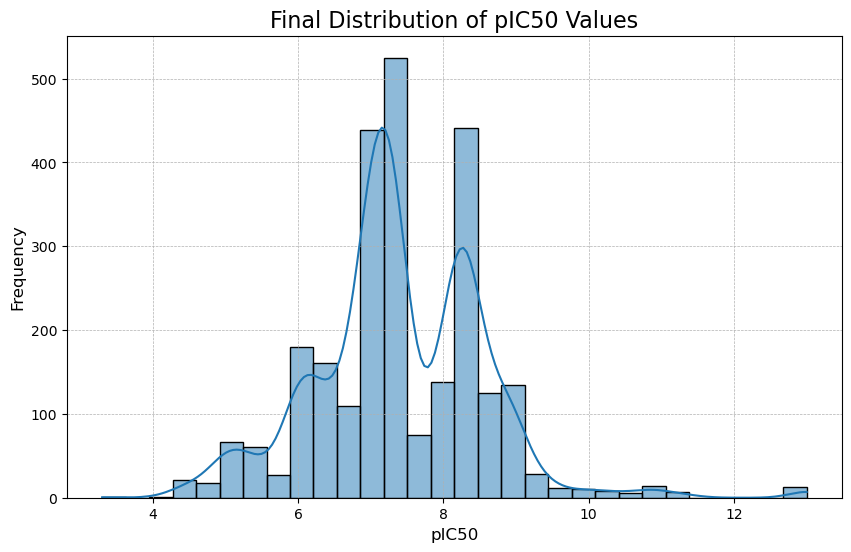

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import MolFromSmiles, MolToSmiles

# --- 1, 2, 3단계는 이전과 동일 ---
# (이전 셀에서 chembl_final, pubchem_final, cas_final이 생성되었다고 가정)

# pIC50 값을 계산하는 함수
def calculate_pic50(row):
    if pd.notna(row['p_value']) and isinstance(row['p_value'], (int, float)):
        return row['p_value']
    value = row['standard_value']
    units = str(row['units']).lower()
    if 'nm' in units: molar_value = value * 1e-9
    elif 'um' in units or 'µm' in units: molar_value = value * 1e-6
    else: return np.nan
    if molar_value > 0: return -np.log10(molar_value)
    else: return np.nan

# pIC50 컬럼 추가
for df in [chembl_final, pubchem_final, cas_final]:
    df['pIC50'] = df.apply(calculate_pic50, axis=1)
    df.dropna(subset=['pIC50'], inplace=True)

# 데이터 통합
combined_df = pd.concat([
    chembl_final[['smiles', 'pIC50']],
    pubchem_final[['smiles', 'pIC50']],
    cas_final[['smiles', 'pIC50']]
], ignore_index=True)

# SMILES 표준화 함수
def standardize_smiles(smiles):
    try:
        mol = MolFromSmiles(smiles)
        return MolToSmiles(mol)
    except:
        return None

# 표준 SMILES 생성 및 중복 처리
combined_df['canonical_smiles'] = combined_df['smiles'].apply(standardize_smiles)
combined_df.dropna(subset=['canonical_smiles'], inplace=True)
final_df = combined_df.groupby('canonical_smiles')['pIC50'].mean().reset_index()
final_df = final_df.rename(columns={'canonical_smiles': 'smiles'})

print(f"중복 처리 후 최종 데이터 행 수: {len(final_df)}")
print("\n--- 최종 통합 데이터셋 (상위 5개) ---")
print(final_df.head())


# --- 4. 최종 데이터 분포도 시각화 ---

plt.figure(figsize=(10, 6))
sns.histplot(final_df['pIC50'].values, kde=True, bins=30)
plt.title('Final Distribution of pIC50 Values', fontsize=16)
plt.xlabel('pIC50', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, ls="--", linewidth=0.5)

# 생성된 플롯을 이미지 파일로 저장
plt.savefig('../outputs/figures/final_pic50_distribution.png', dpi=300)
# 따옴표와 괄호를 닫아주어 오류 수정
print("\n'outputs/figures/final_pic50_distribution.png' 파일에 최종 분포도 플롯이 저장되었습니다.") # (!!! 수정된 부분 !!!)

# 최종 데이터셋을 파일로 저장하여 다음 노트북에서 사용
final_df.to_csv('../data/processed/ask1_master_final.csv', index=False)
print("'data/processed/ask1_master_final.csv' 파일에 최종 데이터셋이 저장되었습니다.")

중복 처리 후 최종 데이터 행 수: 2620

--- 최종 통합 데이터셋 (상위 5개) ---
                                              smiles    pIC50
0                        Brc1ccc2nc(Nc3ccccc3)ncc2c1  5.00000
1  C#CC1CCc2nnc(-c3cccc(NC(=O)c4cc(-n5cnc(C6CC6)c...  8.44370
2  C#CCCCC(=O)N[C@@H](Cc1ccc(C(=O)c2ccccc2)cc1)C(...  5.69897
3  C#CCCCC(=O)N[C@H](Cc1ccc(C(=O)c2ccccc2)cc1)C(=...  5.69897
4  C#C[C@@H]1CCc2nnc(-c3cccc(NC(=O)c4cc(-n5cnc(C6...  8.72125

'outputs/figures/final_pic50_distribution.png' 파일에 최종 분포도 플롯이 저장되었습니다.
'data/processed/ask1_master_final.csv' 파일에 최종 데이터셋이 저장되었습니다.


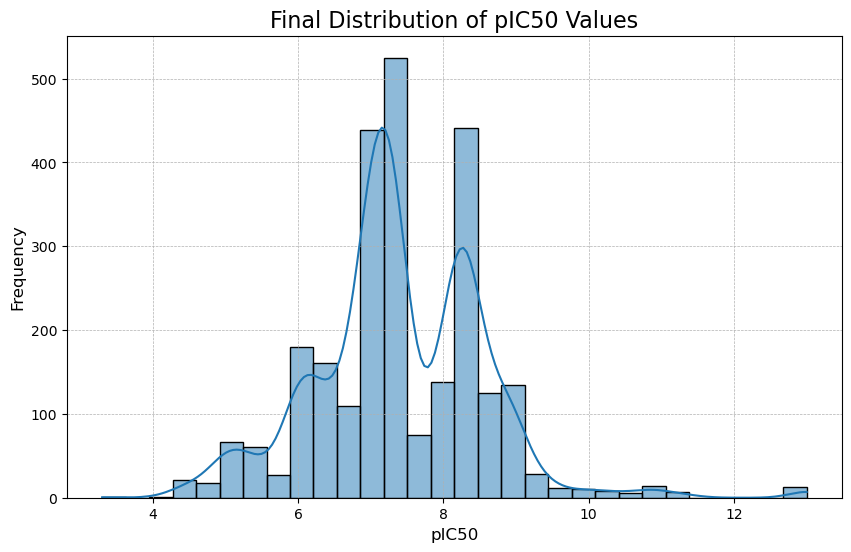

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import MolFromSmiles, MolToSmiles

# (이전 셀에서 chembl_final, pubchem_final, cas_final이 생성되었다고 가정)

# pIC50 값을 계산하는 함수
def calculate_pic50(row):
    if pd.notna(row['p_value']) and isinstance(row['p_value'], (int, float)):
        return row['p_value']
    value = row['standard_value']
    units = str(row['units']).lower()
    if 'nm' in units: molar_value = value * 1e-9
    elif 'um' in units or 'µm' in units: molar_value = value * 1e-6
    else: return np.nan
    if molar_value > 0: return -np.log10(molar_value)
    else: return np.nan

# pIC50 컬럼 추가
for df in [chembl_final, pubchem_final, cas_final]:
    df['pIC50'] = df.apply(calculate_pic50, axis=1)
    df.dropna(subset=['pIC50'], inplace=True)

# 데이터 통합
combined_df = pd.concat([
    chembl_final[['smiles', 'pIC50']],
    pubchem_final[['smiles', 'pIC50']],
    cas_final[['smiles', 'pIC50']]
], ignore_index=True)

# SMILES 표준화 함수
def standardize_smiles(smiles):
    try:
        mol = MolFromSmiles(smiles)
        return MolToSmiles(mol)
    except:
        return None

# 표준 SMILES 생성 및 중복 처리
combined_df['canonical_smiles'] = combined_df['smiles'].apply(standardize_smiles)
combined_df.dropna(subset=['canonical_smiles'], inplace=True)
final_df = combined_df.groupby('canonical_smiles')['pIC50'].mean().reset_index()
final_df = final_df.rename(columns={'canonical_smiles': 'smiles'})

print(f"중복 처리 후 최종 데이터 행 수: {len(final_df)}")
print("\n--- 최종 통합 데이터셋 (상위 5개) ---")
print(final_df.head())


# 최종 데이터 분포도 시각화
plt.figure(figsize=(10, 6))
sns.histplot(final_df['pIC50'].values, kde=True, bins=30)
plt.title('Final Distribution of pIC50 Values', fontsize=16)
plt.xlabel('pIC50', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, ls="--", linewidth=0.5)

plt.savefig('../outputs/figures/final_pic50_distribution.png', dpi=300)
print("\n'outputs/figures/final_pic50_distribution.png' 파일에 최종 분포도 플롯이 저장되었습니다.")

final_df.to_csv('../data/processed/ask1_master_final.csv', index=False)
print("'data/processed/ask1_master_final.csv' 파일에 최종 데이터셋이 저장되었습니다.")